# Simulate resting state dynamics in mouse brain

This demo shows how to simulate and analyze resting state dynamics in mouse brain using as connectome a tracer-based connectome built thanks to the Allen Connectivity Builder.

The results showed here are discussed in Melozzi et al., 2016 [1]



First, we import all the required dependencies

In [1]:
from tvb.interfaces.command.lab import *
from tvb.simulator.lab import *
LOG = get_logger('demo')
from tvb.simulator.plot.tools import *
import numpy as np
import pylab
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

2020-10-28 14:19:48,776 - WARNING - tvb.config.init.introspector_registry - Skipped Adapter(probably because MATLAB not found):<class 'tvb.adapters.analyzers.bct_adapters.DistanceDBIN'>
2020-10-28 14:19:48,777 - WARNING - tvb.config.init.introspector_registry - Skipped Adapter(probably because MATLAB not found):<class 'tvb.adapters.analyzers.bct_adapters.DistanceDWEI'>
2020-10-28 14:19:48,777 - WARNING - tvb.config.init.introspector_registry - Skipped Adapter(probably because MATLAB not found):<class 'tvb.adapters.analyzers.bct_adapters.DistanceNETW'>
2020-10-28 14:19:48,778 - WARNING - tvb.config.init.introspector_registry - Skipped Adapter(probably because MATLAB not found):<class 'tvb.adapters.analyzers.bct_adapters.DistanceRDA'>
2020-10-28 14:19:48,779 - WARNING - tvb.config.init.introspector_registry - Skipped Adapter(probably because MATLAB not found):<class 'tvb.adapters.analyzers.bct_adapters.DistanceRDM'>
2020-10-28 14:19:48,780 - WARNING - tvb.config.init.introspector_registr

2020-10-28 14:19:53,169 - WARNING - tvb.core.services.import_service - Project has been only partially imported because of some missing dependent datatypes. 7 files were successfully imported from a total of 7!
   INFO  log level set to INFO


## The Connectome

In order to built the mouse brain network we used a tracer-based connectome.

In particular we used a structural connectivity matrix (stored in the data folder of TVB), which is built thanks to the Allen Connectivity Builder in TVB.
The Allen Connectivity Builder is a tool that download and manipulate the open-source tracer experiments of the Allen Institute (Oh et al., 2014 [2]) in order to built a connectome and the corresponding parcelled volume according to the preferences of the user.

The user can choose:

  * the resolution of the grid volume in which the experimental data have been registered (here 100 $\mu m$).
  * The definition of the connection strength between source region $i$ and target region $j$. (here $w_{ij}=\frac{PD_j}{ID_i}$, where PD=projection density, ID=injection density)

It is possible to choose the characteristics of the brain areas to be included in the parcellation using the two following criteria:
 * Only brain areas where at least one injection has infected more than a given threshold of voxels. This kind of selection ensures that only the data with a certain level of experimental relevance is included in the connectome (Oh et al., 2014[2]), (here 50 voxels).
 * Only brain areas that have a volume greater than a given threshold can be included (here 2$mm^3$).



In the following the connectome is loaded in plotted. 
  

In [2]:
from tvb.basic.readers import try_get_absolute_path
connectivity_path = try_get_absolute_path("tvb_data","mouse/allen_2mm/Connectivity.h5")
import_op = import_conn_h5(1, connectivity_path)
import_op = wait_to_finish(import_op)
import_op

2020-10-28 14:19:58,550 - INFO - tvb.core.services.operation_service - Starting operation TVBImporter
2020-10-28 14:20:02,147 - INFO - tvb.core.services.backend_clients.standalone_client - Finished with launch of operation 8
2020-10-28 14:20:02,154 - INFO - tvb.core.services.operation_service - Finished operation launch:TVBImporter
2020-10-28 14:20:07,170 - INFO - tvb.interfaces.command.lab - Operation finished successfully


<Operation('c93e901dfb864377ab82871df67ab82b', e538f290-1917-11eb-ab2e-faffc245676e, 2,'1','29','2020-10-28 14:19:58.558787','2020-10-28 14:20:01.730416', '2020-10-28 14:20:01.809151','5-FINISHED',True, 'None', '2020-10-28,14-20-01', '', 0)>

In [3]:
list_operation_results(import_op.id)

              id                     type                              gid         date
              17        ConnectivityIndex d9be05424e8011e69bf02c4138a1c4ef 2016-07-20 15:49:59.831038


In [4]:
conn = load_dt(17)

/Users/bvalean/UTILS/anaconda3/envs/tvb-run/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


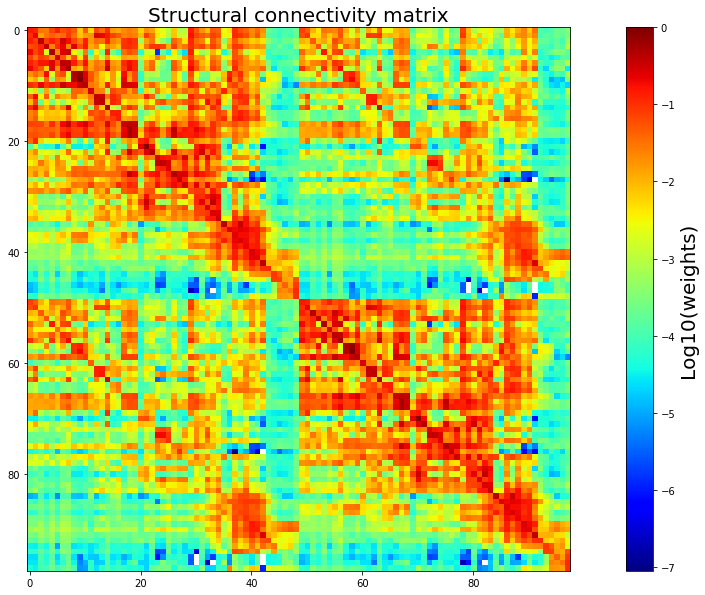

In [5]:
from tvb.basic.readers import try_get_absolute_path

# Visualize the structural connectivity matrix
plt.subplots()
cs=plt.imshow(np.log10(conn.weights), cmap='jet', aspect='equal', interpolation='none')
plt.title('Structural connectivity matrix', fontsize=20)
axcb=plt.colorbar(cs)
axcb.set_label('Log10(weights)', fontsize=20)


## The simulation

Once the brain network is defined is possible to simulate its activity. Here we simulate resting state dynamics using the reduced Wong Wang model (Deco et al. 2013 [3], Hansen et al., 2015 [4]).

In order to convert the synaptic activity in BOLD signals we used the Balloon-Windkessel method (Friston et al., 200 [5]) using the default value implemented in The Virtual Brain.

In [5]:
list_projects()

                    name    id
         Default_Project     1


In [6]:
from tvb.core.services.algorithm_service import AlgorithmService
from tvb.core.services.simulator_service import SimulatorService
from tvb.core.entities.model.model_burst import BurstConfiguration
from tvb.config.init.introspector_registry import IntrospectionRegistry
from tvb.core.entities.file.simulator.view_model import SimulatorAdapterModel, EulerStochasticViewModel, BoldViewModel, AdditiveNoiseViewModel
from time import sleep

# define the neural mass model (here: reduced wong wang)
RWW = models.ReducedWongWang(w=numpy.array([1.0]), I_o=numpy.array([0.3]))

#define variables to monitor during simulation (here: BOLD activity)
monitor = BoldViewModel()
monitor.period=2e3

#define long range coupling parameter
longcoupling = coupling.Linear(a=numpy.array([0.096]))

#define duration of simulation in ms
duration=1200e3

#define integrator
integrator = EulerStochasticViewModel()
integrator.dt = 0.1
integrator.noise = AdditiveNoiseViewModel(nsig=np.array([0.00013]))

# Instantiate a SimulatorAdapterModel and configure it
simulator_model = SimulatorAdapterModel()
simulator_model.model=RWW
# Copy ConnectivityIndex gid from the result of the list_operation_results function
simulator_model.connectivity = "d9be05424e8011e69bf02c4138a1c4ef"
simulator_model.simulation_length = duration
simulator_model.coupling = longcoupling
simulator_model.integrator = integrator
simulator_model.monitors = [monitor]

launched_operation = fire_simulation(1, simulator_model)


launched_operation = wait_to_finish(launched_operation)

launched_operation

2020-10-28 14:22:03,146 - WARNING - tvb.traits - default contains values out of the declared domain. Ex 0.27 
   attribute  tvb.simulator.models.wong_wang.ReducedWongWang.a = NArray(label=':math:`a`', dtype=float64, default=array([0.27]), dim_names=(), ndim=None, required=True)
2020-10-28 14:22:03,147 - WARNING - tvb.traits - Field seems mutable and has a default value. Consider using a lambda as a value factory 
   attribute tvb.simulator.models.wong_wang.ReducedWongWang.state_variable_range = Final(field_type=<class 'dict'>, default={'S': array([0., 1.])}, required=True)
2020-10-28 14:22:03,147 - WARNING - tvb.traits - Field seems mutable and has a default value. Consider using a lambda as a value factory 
   attribute tvb.simulator.models.wong_wang.ReducedWongWang.state_variable_boundaries = Final(field_type=<class 'dict'>, default={'S': array([0., 1.])}, required=True)
2020-10-28 14:22:03,501 - INFO - tvb.interfaces.command.lab - Operation launched ....
2020-10-28 15:17:53,027 - IN

<Operation('949d7c36e19f44a98b0709a4a14128a4', 2f96eeb4-1918-11eb-ab2e-faffc245676e, 2,'1','13','2020-10-28 14:22:03.326190','2020-10-28 14:22:06.549017', '2020-10-28 15:17:52.548255','5-FINISHED',True, 'None', '2020-10-28,15-17-52', '', 516.796875)>

The simulated bold signals can be visualized using matplotlib library.

In [8]:
list_operation_results(launched_operation.id)

              id                     type                              gid         date
              23   SimulationHistoryIndex 830aa77e7b4d41e28af4884e85d020a6 2020-10-28 15:17:52.446986
              24    TimeSeriesRegionIndex 818f42d35e2942b6945f1bf9902cfa55 2020-10-28 15:17:52.509409


In [9]:
#Load time series h5 file
ts = load_dt(24)
bold_time = ts.time
bold_data = ts.data

Text(0.5, 1.0, 'Simulated BOLD timeseries')

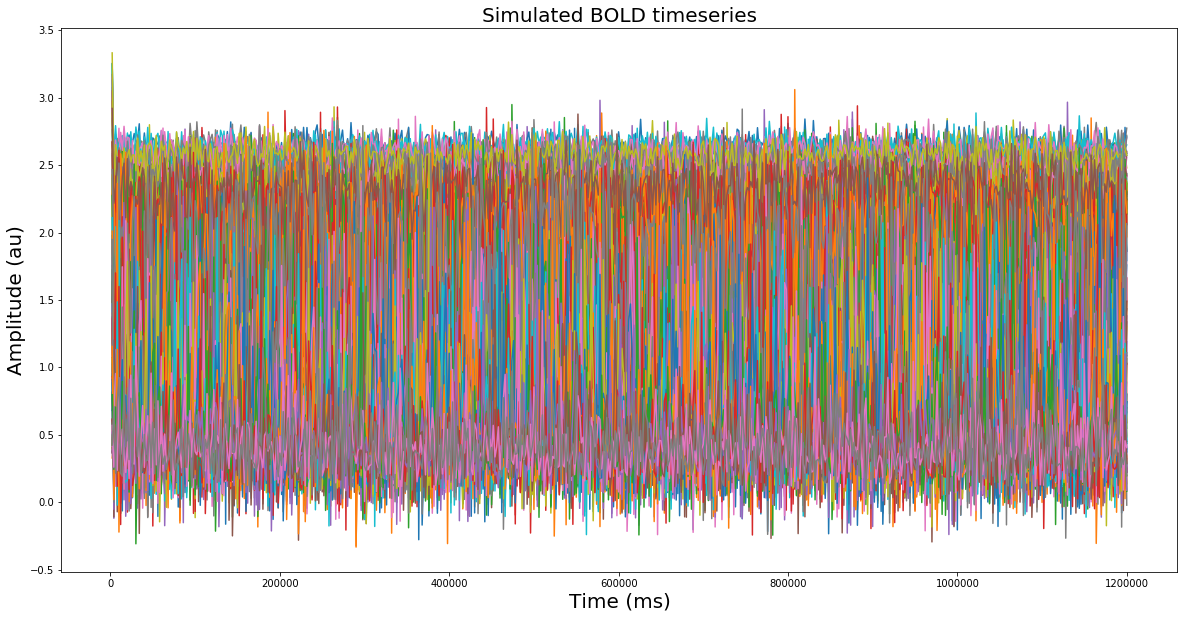

In [10]:
# Display the simulated bold timeseries
plt.subplots()
plt.plot(bold_time,bold_data[:,0,:,0])
plt.xlabel('Time (ms)', fontsize=20)
plt.ylabel('Amplitude (au)', fontsize=20)
plt.title('Simulated BOLD timeseries', fontsize=20)

## Analysis

The simulated BOLD signals can be analyzed in different way. 

### Functional Connectivity Dynamics
In particular here we focus on the Functional Connectivity Dynamics (FCD) a metric which is able to quantify the evolution of the functional states in time. There are several ways to estimate FCD (for a review Preti et al., 2016 [6]), TVB uses the sliding windows technique.


In order to estimate the FCD using the sliding window technique, the entire BOLD time-series is divided in time windows of a fixed length (3 min) and with an overlap of 176 s; the data points within each window centered at the time $t_i$ were used to calculate FC($t_i$). 
The \emph{ij}-th element of the FCD matrix is calculated as the Pearson correlation between the upper triangular part of the $FC(t_i)$ matrix arranged as a vector and the upper triangular part of the $FC(t_j)$ matrix arranged as a vector.


The FCD matrix allows identifying the epochs of stable FC configurations as blocks of elevated inter-$FC(t)$ correlation; these blocks are organized around the diagonal of the FCD matrix (Hansen et al., 2015 [4]).


In order to identify the epochs of stable FC configurations, TVB uses the spectral embedding method, that permits to group together the nodes of the FCD, i.e. the different time windows, in clusters.


In [11]:
# Run FCD Adapter in order to compute the FCD Matrix
from tvb.adapters.analyzers.fcd_adapter import FCDAdapterModel,FunctionalConnectivityDynamicsAdapter
from tvb.adapters.datatypes.db.time_series import TimeSeriesRegionIndex
from tvb.adapters.datatypes.h5.time_series_h5 import TimeSeriesRegionH5
from tvb.core.neocom import h5
from tvb.core.entities.storage import dao
from tvb.core.entities.file.files_helper import FilesHelper
from tvb.core.adapters.abcadapter import ABCAdapterForm, ABCAdapter
from tvb.core.services.operation_service import OperationService
from time import sleep

adapter_instance = ABCAdapter.build_adapter_from_class(FunctionalConnectivityDynamicsAdapter)

# Create and evaluate the analysis
# build FCDAdapterModel
fcd_model = adapter_instance.get_view_model_class()()
#Copy the TimeSeriesRegionIndex gid from the result of the list_operation_results function
fcd_model.time_series= "818f42d35e2942b6945f1bf9902cfa55"
fcd_model.sw=180e3 # windows length (ms)
fcd_model.sp=4e3 # spanning between sliding windows (ms)

# launch an operation and have the results stored both in DB and on disk
launched_operation = fire_operation(1, adapter_instance, fcd_model)

launched_operation = wait_to_finish(launched_operation)

launched_operation

2020-10-28 15:54:27,940 - INFO - tvb.core.services.operation_service - Starting operation FunctionalConnectivityDynamicsAdapter
2020-10-28 15:54:27,984 - INFO - tvb.core.services.operation_service - Finished operation launch:FunctionalConnectivityDynamicsAdapter
2020-10-28 15:54:27,988 - INFO - tvb.interfaces.command.lab - Operation launched....
2020-10-28 15:54:36,292 - INFO - tvb.core.services.backend_clients.standalone_client - Finished with launch of operation 13
2020-10-28 15:54:38,008 - INFO - tvb.interfaces.command.lab - Operation finished successfully


<Operation('e8b9e61226df4389aff23e410da0d821', 1870fd62-1925-11eb-ab2e-faffc245676e, 2,'1','3','2020-10-28 15:54:27.947394','2020-10-28 15:54:31.977859', '2020-10-28 15:54:35.944784','5-FINISHED',True, 'None', '2020-10-28,15-54-35', '', 0)>

In [13]:
list_operation_results(launched_operation.id)

              id                     type                              gid         date
              25                 FcdIndex 0c433198ed9f4c329a301e4aa6dbffb9 2020-10-28 15:54:35.836718
              26 ConnectivityMeasureIndex 86cf347150c449cca29b89593d10873f 2020-10-28 15:54:35.866375
              27 ConnectivityMeasureIndex f53660ee12874ec3827c0a46a574c730 2020-10-28 15:54:35.891115
              28 ConnectivityMeasureIndex 5c81b1a6bcab4cfda448780d9dc48893 2020-10-28 15:54:35.913205


The original and segmented FCD matrices can be visualized using the matplotlib library.


Text(0.5, 1.0, 'FCD segmented')

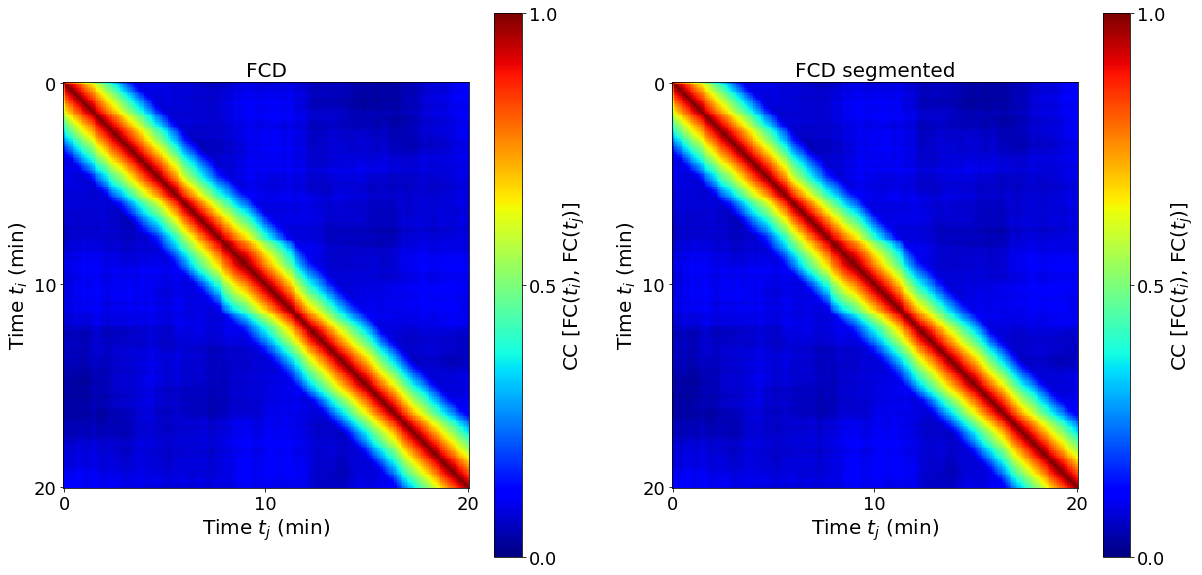

In [14]:
# Plot the FCD matrix and the FCD matrix segmented in the epochs
FCD = load_dt(25).array_data[:,:,0,0]

# If we have just one FCDIndex as a result of the FCD Adapter it means that the FCD Segmented is the same as FCD
FCD_SEGMENTED = FCD
    
plt.subplot(121)
cs=plt.imshow(FCD, cmap='jet', aspect='equal')
axcb =plt.colorbar(ticks=[0, 0.5, 1])
axcb.set_label(r'CC [FC($t_i$), FC($t_j$)]', fontsize=20)
cs.set_clim(0, 1.0)
for t in axcb.ax.get_yticklabels():
     t.set_fontsize(18)
plt.xticks([0,len(FCD)/2-1, len(FCD)-1],['0','10', '20'], fontsize=18)
plt.yticks([0,len(FCD)/2-1, len(FCD)-1],['0','10', '20'], fontsize=18)
plt.xlabel(r'Time $t_j$ (min)', fontsize=20)
plt.ylabel(r'Time $t_i$ (min)', fontsize=20)
plt.title('FCD', fontsize=20)

plt.subplot(122)
cs=plt.imshow(FCD_SEGMENTED, cmap='jet', aspect='equal')
axcb =plt.colorbar(ticks=[0, 0.5, 1])
axcb.set_label(r'CC [FC($t_i$), FC($t_j$)]', fontsize=20)
cs.set_clim(0, 1.0)
for t in axcb.ax.get_yticklabels():
     t.set_fontsize(18)
plt.xticks([0,len(FCD)/2-1, len(FCD)-1],['0','10', '20'], fontsize=18)
plt.yticks([0,len(FCD)/2-1, len(FCD)-1],['0','10', '20'], fontsize=18)
plt.xlabel(r'Time $t_j$ (min)', fontsize=20)
plt.ylabel(r'Time $t_i$ (min)', fontsize=20)
plt.title('FCD segmented', fontsize=20)

### Functional hubs

The functional connectivity matrix of each epoch defines a functional network; for each functional network, TVB identifies the hub regions with an approach analogous to the one used in graph theory for defining the eigenvector centrality of a network node (Newman 2008 [7]). 

Here the functional hub regions of the mouse brain are defined as the regions with the largest eigenvector components, in absolute value, associated with the three largest eigenvalues of the FC matrix.


The functional hubs are an output of the FCD function (that we have just run), so we can save the results and display them in the mouse brain sections.

In [15]:
connectivity_measure_ids = [26,27,28]

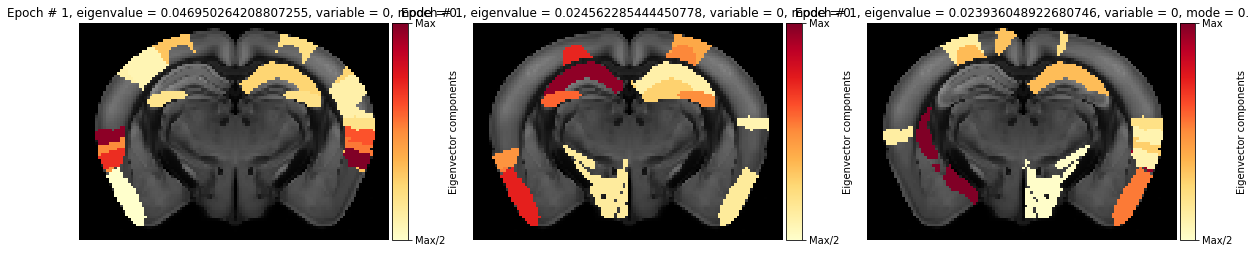

In [16]:
# Plot the functional hubs extracted in the first epoch of stable functional connectivity
# set visualization parameters
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

import h5py
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tvb.basic.readers import try_get_absolute_path

fig, axes = plt.subplots(1,3)
slice_idy=73
j=0
for conn_measure_id in connectivity_measure_ids:
    f_path = try_get_absolute_path("tvb_data", "mouse/allen_2mm/RegionVolumeMapping.h5")
    f = h5py.File(f_path, 'r', libver='latest')
    Vol=f['array_data'][:,:,:]
    f_path = try_get_absolute_path("tvb_data", "mouse/allen_2mm/StructuralMRI.h5")
    f = h5py.File(f_path, 'r', libver='latest')
    template=f['array_data'][:,:,:]
    conn_measure = load_dt(conn_measure_id)
    eig=conn_measure.array_data
    for i in range(np.shape(eig)[0]):
        Vol = np.where(Vol==i, eig[i], Vol)
    Vol = np.ma.masked_where(Vol < (np.amax(eig)/2), Vol)
    im1 = axes[j].imshow((template[:,slice_idy,:].T)[::-1], cmap='gray', vmin=template.min(), vmax=template.max())
    cax = axes[j].imshow((Vol[:,slice_idy,:].T)[::-1], cmap='YlOrRd', alpha=1, vmin=np.amax(eig)/2., vmax=np.amax(eig))
    axes[j].axis('off')
    axes[j].set_title(conn_measure.title)
    divider = make_axes_locatable(axes[j])
    cax1 = divider.append_axes("right", size="5%", pad=0.05)
    axcb=plt.colorbar(cax,cax1,ticks=[np.amax(eig)/2.,np.amax(eig)],orientation='vertical')
    axcb.set_ticklabels(['Max/2', 'Max']) 
    axcb.set_label('Eigenvector components')
    j=j+1

## References

[1] Melozzi, Francesca, Marmaduke Woodman, Viktor Jirsa, and Christophe Bernard. "The Virtual Mouse Brain: A Computational Neuroinformatics Platform To Study Whole Mouse Brain Dynamics." bioRxiv (2017): 123406.


[2] Oh, Seung Wook, Julie A. Harris, Lydia Ng, Brent Winslow, Nicholas Cain, Stefan Mihalas, Quanxin Wang et al. "A mesoscale connectome of the mouse brain." Nature 508, no. 7495 (2014): 207-214.


[3] Deco Gustavo, Ponce Alvarez Adrian, Dante Mantini, Gian Luca Romani, Patric Hagmann and Maurizio Corbetta. Resting-State Functional Connectivity Emerges from Structurally and Dynamically Shaped Slow Linear Fluctuations. The Journal of Neuroscience 32(27), 11239-11252, 2013.


[4] Hansen, Enrique CA, Demian Battaglia, Andreas Spiegler, Gustavo Deco, and Viktor K. Jirsa. "Functional connectivity dynamics: modeling the switching behavior of the resting state." Neuroimage 105 (2015): 525-535.


[5] Friston, Karl J., Andrea Mechelli, Robert Turner, and Cathy J. Price. "Nonlinear responses in fMRI: the Balloon model, Volterra kernels, and other hemodynamics." NeuroImage 12, no. 4 (2000): 466-477.


[6] Preti, Maria Giulia, Thomas AW Bolton, and Dimitri Van De Ville. "The dynamic functional connectome: State-of-the-art and perspectives." NeuroImage (2016).


[7] Newman, Mark EJ. "The mathematics of networks." The new palgrave encyclopedia of economics 2, no. 2008 (2008): 1-12.